In [1]:
%reload_ext autoreload
%autoreload 2
%matplotlib inline

In [2]:
from fastai.text import *

/home/paperspace/projects/jadlg_rnn/lib/python3.6/site-packages/sklearn/ensemble/weight_boosting.py:29: DeprecationWarning: numpy.core.umath_tests is an internal NumPy module and should not be imported. It will be removed in a future NumPy release.
  from numpy.core.umath_tests import inner1d


In [5]:
path = Path('../data/')

In [6]:
df = pd.read_csv(path/'all.csv')
df.head()

,work_id,text,dictionary,context,provenance,comments,updated_at,created_at,theme,id,reviewed_on,metaphor
0,3213.0,"Logitians use to clap a Proposition,<br>\r\n A...",Animals,NaN,"Searching ""rule"" and ""reason"" in HDIS (Poetry)","In this case, not fish-trap as I originally th...",2013-10-04 14:27:45 UTC,2004-06-10 00:00:00 UTC,NaN,8442,2011-06-14,"A Logician is ""one, that has been broke / To R..."
1,3323.0,What raisd their Joy their love coud also rais...,Impression,I've included the entire poem,"Searching ""soul"" and ""impression"" in HDIS (Poe...",NaN,2009-09-14 19:33:39 UTC,2005-05-17 00:00:00 UTC,NaN,8591,NaN,"""Deep in their soules ye fair impression lay, ..."
2,3324.0,"<b>If at the type our dreaming soules awake,<B...",Impression,I've included the entire poem,"Searching ""soul"" and ""impression"" in HDIS (Poe...",<BR>,2009-09-14 19:33:39 UTC,2005-05-17 00:00:00 UTC,NaN,8592,NaN,"""If at the type our dreaming soules awake, / &..."
3,3407.0,"In all mistakes, The Strickt, and Regular,<BR>...",NaN,NaN,"Searching ""mind"" and ""clock"" in HDIS (Poetry)",NaN,2009-09-14 19:33:43 UTC,2006-11-16 00:00:00 UTC,NaN,8698,NaN,"""As no Man mind's those Clocks that use to go ..."
4,5026.0,"""Edward, lo! to sudden fate <BR>""(Weave we the...",Inhabitants,NaN,HDIS,NaN,2009-09-14 19:38:37 UTC,2003-11-11 00:00:00 UTC,NaN,13518,NaN,Unborn ages may crowd on the soul


In [7]:
text = df['text'].astype(str)
metaphor = df['metaphor'].astype(str)
text = [t.lower().replace('\r','').replace('/','').replace('"','').replace("'","").replace("\n","").replace('<br>','').replace('<i>','').replace('--','') for t in text]
metaphor = [t.lower().replace('\r','').replace('/','').replace('"','').replace("'","").replace("\n","").replace('<br>','').replace('<i>','').replace('--','') for t in metaphor]

In [8]:
#text[:-3]

In [9]:
c0, c1 = [],[]

for i in range(len(text)):
    text[i] = re.sub('\x0b','',text[i])
    t = re.sub('<b>.*<b>',' xxmsk ',text[i]).split(' xxmsk ')
    c0.append(t[0])
    if len(t) > 1:  c1.append(t[1])
    else: c1.append('')
    #text[i] = re.sub('<.*>','',text[i])
    #metaphor[i] = re.sub('<.*>','',metaphor[i])
    #text[i] = re.sub('\x0b','',text[i])
    metaphor[i] = re.sub('\x0b','',metaphor[i])
    #text[i].replace('.(p','')
    #text[i].replace(' ','')
    #text[i].replace('.(pp','')
    
    #metaphor[i] = re.sub('(.*)','',metaphor[i])

In [10]:
c0[5],c1[5],metaphor[5]

('the verse adorn again fierce war and faithful love, and truth severe, by fairy fiction dressed. in buskined measures move pale grief and pleasing pain, with ',
 '.a voice as of the cherub-choir gales from blooming eden bear; and distant warblings lessen on my ear, that lost in long futurity expire. fond impious man, thinkst thou yon sanguine cloud, raised by thy breath, has quenched the orb of day? tomorrow he repairs the golden flood, and warms the nations with redoubled ray. enough for me: with joy i see the different doom our fates assign. be thine despair and sceptered care; to triumph, and to die, are mine. he spoke, and headlong from the mountains height deep in the roaring tide he plunged to endless night. (ll. 125-44, pp. 198-200)',
 'horror may be a tyrant of the throbbing breast')

In [11]:
tok_c0 = Tokenizer.proc_all(c0,lang='en')
tok_c1 = Tokenizer.proc_all(c1,lang='en')
tok_tgt = Tokenizer.proc_all(metaphor,lang='en')
len(tok_tgt)

14957

In [15]:
#tok_src[0], tok_tgt[0]

In [9]:
#tokenizer = Tokenizer()

In [10]:
#def mask_sequences(texts):
#    masked_text = []
#    for text in texts:
#        for token in tokenizer.tok(text):
#            if token.pos_ == 'VERB' and not token.is_stop:
#                text = text.replace(str(token),' xxmsk ')
#        masked_text.append(text)
#    return masked_text

In [11]:
#masked_metaphor = mask_sequences(metaphor)
#masked_metaphor[:10]

In [12]:
#masked_metaphor = [text.replace(' xxmsk ','xxmsk') for text in masked_metaphor]
#masked_metaphor[:10]

In [13]:
#pickle.dump(masked_metaphor, open(path/'metaphors_masked.pkl','wb'))

In [14]:
#masked_metaphor = pickle.load(open(path/'metaphors_masked.pkl','rb'))
#len(masked_metaphor)

In [12]:
import collections

def toks2ids(tok, pre,is_src=True,ovrt=False):
    if ovrt:
        freq = collections.Counter(p for o in tok for p in o)
        itos = [o for o,c in freq.most_common(20000)]
        itos.insert(0, 'xxunk')
        itos.insert(1, 'xxpad')
        itos.insert(2, 'xxbos')
        #itos.insert(3, 'xxmsk')
        stoi = collections.defaultdict(lambda: 0, {v:k for k,v in enumerate(itos)})
        pickle.dump(itos, open(path/f'{pre}_itos.pkl', 'wb'))
    else: 
        itos = pickle.load(open(path/f'{pre}_itos.pkl', 'rb'))
        stoi = collections.defaultdict(lambda: 0, {v:k for k,v in enumerate(itos)})
    return itos,stoi

In [17]:
#tok_src = Tokenizer.proc_all(masked_metaphor,lang='en')
#tok_tgt = Tokenizer.proc_all(metaphor,lang='en')
#len(tok_src), len(tok_tgt)

In [13]:
itos,stoi = toks2ids(tok_c0+tok_c1+tok_tgt,'metaphors',ovrt=True)
#itos,stoi = toks2ids(tok_tgt,'metaphors',ovrt=False)
c0_ids = np.array([[2]+[stoi[o] for o in p] for p in tok_c0])
c1_ids = np.array([[2]+[stoi[o] for o in p] for p in tok_c1])
tgt_ids = np.array([[2]+[stoi[o] for o in p] for p in tok_tgt])
len(itos),len(c0_ids),len(tgt_ids)

(20003, 14957, 14957)

In [14]:
#c0_ids[0], tgt_ids[0]

In [15]:
trn_c0,val_c0,trn_c1,val_c1,trn_tgt,val_tgt = sklearn.model_selection.train_test_split(c0_ids,c1_ids,tgt_ids,test_size=0.1,shuffle=False)

In [16]:
len(trn_c0), len(trn_tgt), len(val_c0), len(val_tgt)

(13461, 13461, 1496, 1496)

In [17]:
#trn_c0[:2], trn_c1[:2],trn_tgt[:2]

In [18]:
import io

def load_vectors(fname):
    fin = io.open(fname, 'r', encoding='utf-8', newline='\n', errors='ignore')
    header = fin.readline().split()
    n, d = header[0], header[1]
    data = {}
    #partitions = [fin[:]]
    for line in fin:
        tokens = line.rstrip().split(' ')
        data[tokens[0]] = np.array(tokens[1:], dtype=float)
    return data, n, d

In [19]:
en_vecs, vs, dim_en_vec = load_vectors('/home/paperspace/projects/seq2seq_bot/data/wiki-news-300d-1M.vec')

In [22]:
class MaskDataset(Dataset):
    def __init__(self, c0, c1,tgt):
        self.c0 = c0
        self.c1 = c1
        self.tgt = tgt
        self.ml = 100
    def __getitem__(self, idx):
        return A(self.c0[idx][-self.ml:]), A(self.c1[idx][-self.ml:]), A(self.tgt[idx][-self.ml:]),A(self.tgt[idx][-self.ml:])
    def __len__(self): return len(self.src)

In [23]:
trn_seq2seq_ds = MaskDataset(trn_c0,trn_c1,trn_tgt)
val_seq2seq_ds = MaskDataset(val_c0,val_c1,val_tgt)

In [24]:
bs=64

trn_samp = SortishSampler(trn_c0, lambda x: len(trn_c0[x]), bs)
val_samp = SortSampler(val_c0, lambda x: len(val_c0[x]))

trn_seq2seq_dl = DataLoader(trn_seq2seq_ds,batch_size=bs,pad_idx=1,num_workers=1,pre_pad=False, transpose_y=True, transpose=True, sampler=trn_samp)
val_seq2seq_dl = DataLoader(val_seq2seq_ds,batch_size=bs,pad_idx=1,num_workers=1,pre_pad=False, transpose_y=True, transpose=True, sampler=val_samp)

In [25]:
c0, c1, x, y = next(iter(trn_seq2seq_dl))
c0.size(), c1.size(), x.size(), y.size()

(torch.Size([100, 64]),
 torch.Size([100, 64]),
 torch.Size([64, 100]),
 torch.Size([64, 100]))

In [26]:
md = ModelData(path, trn_seq2seq_dl, val_seq2seq_dl)

In [27]:
def rand_t(*sz): return torch.randn(sz)/math.sqrt(sz[0])
def rand_p(*sz): return nn.Parameter(rand_t(*sz))

In [28]:
def seq2seq_loss(input, target, kld_weight=0):
    decoded = input
    sl, bs = target.size()
    sl_in,bs_in,nc = decoded.size()
    if sl>sl_in: decoded = F.pad(decoded, (0,0,0,0,0,sl-sl_in))
    decoded = decoded[:sl]
    return F.cross_entropy(decoded.view(-1,nc), target.view(-1))

In [29]:
def create_emb(vecs, itos, em_sz):
    emb = nn.Embedding(len(itos), em_sz, padding_idx=1)
    wgts = emb.weight.data
    miss = []
    for i,w in enumerate(itos):
        try: wgts[i] = torch.from_numpy(vecs[w])
        except: miss.append(w)
    print(len(miss),miss[5:10])
    return emb

In [151]:
class VAE(nn.Module):
    def __init__(self,vs,vecs,itos,em_sz,latent_sz,nh,nl=2, dropf=1,wdrop=0,kld_weight=1e-3):
        super().__init__()
        self.initrange=0.1
        self.wdrop,self.kld_weight = wdrop,kld_weight
        self.nl,self.nh, self.vs,self.em_sz,self.latent_sz = nl,nh,vs,em_sz,latent_sz
        #encoder
        self.emb_enc = create_emb(vecs,itos,em_sz)
        self.emb_enc_drop = nn.Dropout(0.15*dropf)
        self.gru_enc = nn.GRU(em_sz, nh, num_layers=nl, dropout=0.25*dropf, bidirectional=True)
        self.out_drop = nn.Dropout(0.35*dropf)
        #latent space layers
        self.h2m = nn.Linear(nh*nl*2*3, latent_sz)
        self.h2m.weight.data.uniform_(-self.initrange, self.initrange)
        self.h2log = nn.Linear(nh*nl*2*3, latent_sz)
        self.h2log.weight.data.uniform_(-self.initrange, self.initrange)
        self.z2h = nn.Linear(latent_sz, nh*nl*2*3)
        #self.z2h.weight.data.uniform_(-self.initrange, self.initrange)
        #decoder
        self.gru_dec = nn.GRU(em_sz+latent_sz, nh*2*3, num_layers=nl, dropout=0.25*dropf)
        self.out = nn.Linear(nh*2*3, vs)
        self.out.weight.data.uniform_(-self.initrange, self.initrange)
        self.pr_force = 1.
        
    def forward(self, inp, y=None):
        #encode
        c0,c1,x = inp
        x = x.transpose(1,0)
        sl,bs = x.size()
        hidden = self.initHidden(bs) # nl*bs*nh
        
        emb1 = self.emb_enc_drop(self.emb_enc(c0)) #sl*bs*em_sz
        _, hidden = self.gru_enc(emb1,hidden) #enc_out: sl*bs*nh, hidden: (2*nl)*bs*nh
        h1 = hidden.view(2,2,bs,-1).permute(0,2,1,3).contiguous().view(self.nl,bs,-1)
        
        emb2 = self.emb_enc_drop(self.emb_enc(x)) #sl*bs*em_sz
        _, hidden = self.gru_enc(emb2,hidden) #enc_out: sl*bs*nh, hidden: (2*nl)*bs*nh
        h2 = hidden.view(2,2,bs,-1).permute(0,2,1,3).contiguous().view(self.nl,bs,-1)
        
        emb3 = self.emb_enc_drop(self.emb_enc(c1)) #sl*bs*em_sz
        _, hidden = self.gru_enc(emb3,hidden) #enc_out: sl*bs*nh, hidden: (2*nl)*bs*nh
        h3 = hidden.view(2,2,bs,-1).permute(0,2,1,3).contiguous().view(self.nl,bs,-1)
        
        hidden = torch.cat([h1,h2,h3],2)
        
        mu,logvar = self.h2m(hidden.view(bs,-1)),self.h2log(hidden.view(bs,-1))
        std = torch.exp(0.5 * logvar)
        eps = V(torch.randn(mu.size())) #bs*latent_sz
        z = eps * std + mu #bs*latent_sz
        #decode
        hidden = self.z2h(z)
        #hidden = self.initHidden(bs).view(self.nl,bs,self.nh*2)
        dec_seq = x.clone()
        #word dropout
        if self.wdrop > 0: 
            prob = V(torch.rand(dec_seq.size())) 
            prob[(dec_seq.data - stoi['xxbos']) * (dec_seq.data - stoi['xxpad']) == 0] = 1
            dec_seq[prob < self.wdrop] = stoi['xxunk']
        
        res = []
        dec_inp = V(torch.zeros(bs)+stoi['xxbos']).long()
        
        for i in range(sl):
            dec_emb = self.emb_enc(dec_inp)
            gru_inp = torch.cat([dec_emb,z], 1).unsqueeze(0)
            outp, hidden = self.gru_dec(gru_inp, hidden) #output: sl*bs*(nh*nl*2), hidden: (nl*2)*bs*nh
            #hidden = hidden.view(2,2,bs,-1).permute(0,2,1,3).contiguous().view(self.nl,bs,-1)
            outp = self.out(self.out_drop(outp[0])) #bs*vs
            res.append(outp)
            if (random.random()>self.pr_force):
                dec_inp = dec_seq[i]
            else:
                dec_inp = V(outp.data.max(1)[1])
            if (dec_inp==1).all(): break
        return torch.stack(res), mu, logvar, z
    
    def inference(self,z):
        res =[]
        bs,_ = z.size()
        #samples = V(torch.zeros(MAX_LENGTH, bs).long())
        #z = V(torch.randn([bs, self.latent_sz]))
        hidden = self.z2h(z)
        #hidden = h = V(torch.zeros(self.nl, bs, self.nh*2*3))
        dec_inp = V(torch.zeros(bs)+stoi['xxbos']).long()
        for i in range(MAX_LENGTH):
            emb = self.emb_enc(dec_inp)
            gru_inp = torch.cat([emb,z],1).unsqueeze(0)
            outp, hidden = self.gru_dec(gru_inp, hidden)
            
            outp = self.out(outp[0])
            res.append(outp)
            #dec_inp = V(torch.topk(outp,1,-1)[1]).squeeze(1)
            dec_inp = V(outp.data.max(1)[1])
            outp = F.log_softmax(outp, dim=1)
            outp = torch.multinomial(torch.exp(outp), 1)
            #samples[i, :] = outp.view(-1).data
            dec_inp = V(outp.view(-1))
            if (dec_inp==1).all(): break
        return torch.stack(res)
    
    def initHidden(self, bs):
        h = V(torch.zeros(self.nl*2, bs, self.nh))
        #if torch.cuda.is_available(): h = h
        return h

In [152]:
def kl_anneal_function(anneal_function, step, k, x0):
    if anneal_function == 'logistic':
        return float(1/(1+np.exp(-k*(step-x0))))
    elif anneal_function == 'linear':
        return min(1, step/x0)

In [153]:
def vae_loss(input, target, kld_weight):
    decoded, mu, logvar, z = input
    sl, bs = target.size()
    sl_in,bs_in,nc = decoded.size()
    if sl>sl_in: decoded = F.pad(decoded, (0,0,0,0,0,sl-sl_in))
    decoded = decoded[:sl]
    #loss = seq2seq_loss(decoded, target)
    loss = F.cross_entropy(decoded.view(-1,nc), target.contiguous().view(-1))
    KL_loss = -0.5 * torch.sum(1 + logvar - mu.pow(2) - logvar.exp())
    loss += KL_loss * kld_weight
    return loss

In [154]:
class VAEStepper(Stepper):
    
    def step(self, x, y, epoch, an_f='logistic',kld_start_inc=5):
        xtra = []
        #self.m.wdrop = 0.1 if epoch>4 else 0
        self.m.pr_force = (10-epoch)*0.1 if epoch<10 else 0
        y = y.transpose(1,0)
        output = self.m(x, y)
        if isinstance(output,tuple): output,*xtra = output
        self.opt.zero_grad()
        loss = raw_loss = self.crit([output]+xtra, y, self.m.kld_weight)
        loss.backward()
        if epoch > kld_start_inc:
            self.m.kld_weight = kl_anneal_function(an_f,epoch,self.m.kld_weight,kld_start_inc)
        if self.clip:   # Gradient clipping
            nn.utils.clip_grad_norm_(trainable_params_(self.m), self.clip)
        self.opt.step()
        return raw_loss.data.item()
    
    def evaluate(self, x, y):
        self.m.eval()
        xtra = []
        #x = x[0]
        y = y.transpose(1,0)
        output = self.m(x, y)
        #decoded, m, l, z = output
        if isinstance(output,tuple): output,*xtra = output
#        loss = raw_loss = self.crit([output]+xtra,y, kld_weight)
    
        return output, self.crit([output]+xtra,y, self.m.kld_weight)

In [155]:
nh = 64
nl = 2
vs = len(itos)
em_sz = int(dim_en_vec)
#latent_sz = em_sz
latent_sz = 16
vae = VAE(vs,en_vecs,itos,em_sz,latent_sz,nh,nl=nl)
vae.cuda()

2488 ['em>.', 'fancys', '.(p', 'formd', 'lovd']


VAE(
  (emb_enc): Embedding(20003, 300, padding_idx=1)
  (emb_enc_drop): Dropout(p=0.15)
  (gru_enc): GRU(300, 64, num_layers=2, dropout=0.25, bidirectional=True)
  (out_drop): Dropout(p=0.35)
  (h2m): Linear(in_features=768, out_features=16, bias=True)
  (h2log): Linear(in_features=768, out_features=16, bias=True)
  (z2h): Linear(in_features=16, out_features=768, bias=True)
  (gru_dec): GRU(316, 384, num_layers=2, dropout=0.25)
  (out): Linear(in_features=384, out_features=20003, bias=True)
)

In [156]:
opt_fn = partial(optim.Adam, betas=(0.7, 0.8))

In [157]:
learn = RNN_Learner(md, SingleModel(to_gpu(vae)), opt_fn=opt_fn)
learn.crit = vae_loss

 66%|██████▌   | 139/211 [00:34<00:18,  3.99it/s, loss=21.9]

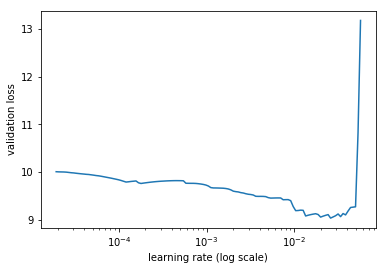

In [158]:
learn.lr_find(stepper=VAEStepper)
learn.sched.plot()

In [159]:
lr=1e-3

In [160]:
learn.fit(lr, 1, cycle_len=25, stepper=VAEStepper, use_clr=(32,10))

epoch      trn_loss   val_loss                              
    0      9.200713   9.145822  
    1      9.16312    9.23193                               
    2      8.730082   8.821178                              
    3      6.104682   7.789285                              
    4      3.669525   4.540858                              
    5      2.826545   2.917815                              
    6      2.497831   2.476858                              
    7      2.26756    2.320552                              
    8      2.171268   2.243575                              
    9      2.134847   2.092973                              
    10     2.061799   2.022212                              
    11     2.049577   2.015715                              
    12     2.005237   2.004862                              
    13     1.95447    2.001663                              
    14     1.995685   1.996094                              
    15     1.94997    1.992944                      

[1.9908683440264534]

In [202]:
learn.save('vae_metaphors')

In [203]:
learn.load('vae_metaphors')

In [53]:
learn.fit(lr/10, 1, cycle_len=8, stepper=VAEStepper, use_clr=(20,8))

epoch      trn_loss   val_loss                              
    0      4.960727   5.174614  
    1      4.278578   5.172833                              
    2      4.844539   5.17032                               
    3      4.416083   5.168694                              
    4      4.287536   5.169852                              
    5      4.149753   5.174025                              
    6      4.161283   5.172613                              
    7      4.239572   5.173017                              


[5.173016836298978]

In [194]:
def produce_out(val_dl, model, interval=(0,10)):
    
    model.eval()
    out = []
    ds = next(iter(val_dl))
    c0,c1,x,y = ds
    y = y.transpose(1,0)
    #x = x.transpose(1,0)
    bs, sl = x.size()
    model.wdrop=0
    model.pr_force=1
    #x = x.long()
    #if use_cuda:
    #    x = x.cuda()
    decoded, mu, logvar, z = model((c0,c1,x))
    #z = V(torch.randn((bs,model.latent_sz)))
    probs = model.inference(z)
    #preds = np.array(decoded.max(2)[1])
    preds = np.array(probs.max(2)[1])
    for i in range(interval[0], interval[-1]):
        out.append([' '.join(itos[o] for o in c0[:,i] if o not in [1,2]), \
                    ' '.join(itos[o] for o in x[:,i] if o not in [1,2]), \
                    ' '.join(itos[o] for o in preds[:,i] if o not in [0,1,2]), \
                    ' '.join(itos[o] for o in c1[:,i] if o not in [1,2])])
    return out,z

In [195]:
MAX_LENGTH=100
out,z = produce_out(trn_seq2seq_dl, learn.model)

In [196]:
out[2][0]+out[2][1]+out[2][-1]

'was the same impropriety in the same epithet bestowed upon richard iii . king of england , who , he says , was one of the best - made men of the age in which he lived : but here [ page 24 ] i must contradict the said buck , from my own knowledge . richard had , undoubtedly , one shoulder higher than the other , and his left arm was a little shrunk and contracted : but , notwithstanding the ungracious colours in which he has been drawn by the flatterers of the house of xxunk ,never wretched can may i]f minds wit oer have m]y i friendship empire pours body is wretch ! bliss my body monstrous may my like lockes art tree most love a those reason this t]he booby lifes motion the difference , though me novelty this annoyance , , hearts got xxunk i i if body , as in thy this then is need maythe least qualified subjects , and xxunk merit , his new xxunk concluded ( not without some shadow of reason ) that xxunk - xxunk being unknown to the prime minister , was a sort of negative presumption i

In [197]:
out[2][0]+out[2][2]+out[2][-1]

'was the same impropriety in the same epithet bestowed upon richard iii . king of england , who , he says , was one of the best - made men of the age in which he lived : but here [ page 24 ] i must contradict the said buck , from my own knowledge . richard had , undoubtedly , one shoulder higher than the other , and his left arm was a little shrunk and contracted : but , notwithstanding the ungracious colours in which he has been drawn by the flatterers of the house of xxunk ,the the who , to thousand to to been , to much the , that had the same impression of had and mind were a as , and they were , , into to mind , of the soul , , the the thing , and the not be have to is the , that the soul is been the mind mind , we own own empire to , ,the least qualified subjects , and xxunk merit , his new xxunk concluded ( not without some shadow of reason ) that xxunk - xxunk being unknown to the prime minister , was a sort of negative presumption in favour of his character . this officer was a

In [198]:
out[2][1], out[2][2]

('never wretched can may i]f minds wit oer have m]y i friendship empire pours body is wretch ! bliss my body monstrous may my like lockes art tree most love a those reason this t]he booby lifes motion the difference , though me novelty this annoyance , , hearts got xxunk i i if body , as in thy this then is need may',
 'the the who , to thousand to to been , to much the , that had the same impression of had and mind were a as , and they were , , into to mind , of the soul , , the the thing , and the not be have to is the , that the soul is been the mind mind , we own own empire to , ,')

In [199]:
def interpolate(start, end, steps):

    interpolation = np.zeros((start.shape[0], steps + 2))

    for dim, (s,e) in enumerate(zip(start,end)):
        interpolation[dim] = np.linspace(s,e,steps+2)

    return interpolation.T

In [200]:
z1 = torch.randn([latent_sz]).numpy()
z2 = torch.randn([latent_sz]).numpy()
z = V(torch.from_numpy(interpolate(start=z1, end=z2, steps=8)).float())
samples = learn.model.inference(z)

In [117]:
samples.size()

torch.Size([50, 10, 20003])

In [201]:
samples = np.array(samples.max(2)[1])
samples = samples.T
[' '.join(itos[o] for o in sample if o not in [0,1,2]) for sample in samples]

['the me minds be mind , , , ,',
 'the up the , the own , and he is impression with to and to be , and of a to be , thousand in in the heart and of - were , and',
 'the the same of ideas , which , the be the to the , and the thing of the mind ,',
 ', the the , and it are the and the mind of the , and is is , to , it be . it it of is the more . to .',
 'the the , , that the the , the - , the , much , and the same of the heart mind ,',
 'the ! heart , in ,',
 'much , , that , the impression , the mind little of , and the , , the and , and the the of and the the mind of the , longer , the the is the and be the the , that the the the - , , the of which is in the minds , and the , not , are , that man , which the mind are been been , and the into into the the the in image from the , . the .',
 'had a the the of the a the same manner , ideas , had , he minds are , the , and , well in , , the mind , and , as , and own , the , the , and the it same of the . , is not by of the body , it the be 